# <center>TMVA Classification Using Deep Neural Networks</center>

In this notebook we still classify di-Higgs new data with Deep Neural Networks meethod.

In [1]:
import ROOT
from ROOT import TMVA, TTree
import pandas as pd

ROOT.TMVA.Tools.Instance()
## For PYMVA methods
TMVA.PyMethodBase.PyInitialize()

import os
os.environ["KERAS_BACKEND"] = "tensorflow"

from keras.models import Sequential
from keras.optimizers import Adam, SGD
#from keras.initializers import TruncatedNormal
#from keras import initializations
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Reshape
#from keras.callbacks import ReduceLROnPlateau

import itertools
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from array import array
import numpy as np

from root_numpy import root2array, tree2array

from IPython.display import Image, display

Welcome to JupyROOT 6.14/04


Using TensorFlow backend.


### Filter dataset by region.

This function will let you filter your dataset by region. It's known that SR_1tag is very signal poor, while SR_2tag has a lot a signal.

In [2]:
def filter_region(file, region, signal):
    oldfile = ROOT.TFile(file)
    oldtree = oldfile.Nominal
    signal_file = ROOT.TFile(region+"_"+signal+"_s.root","recreate")
    signal_tree = oldtree.CloneTree(0)
    backg_file = ROOT.TFile(region+"_"+signal+"_b.root","recreate")
    backg_tree = oldtree.CloneTree(0)
    data_file = ROOT.TFile(region+"_"+signal+"_d.root","recreate")
    data_tree = oldtree.CloneTree(0)
    for entry in oldtree:
        if (entry.m_region == region):
            if (entry.sample == "data"):
                data_tree.Fill()
            elif (entry.sample == "Xtohh1000"): #signal
                signal_tree.Fill()
            else:
                backg_tree.Fill()
    signal_tree.AutoSave()   
    backg_tree.AutoSave()
    data_tree.AutoSave()
    return signal_tree, signal_file, backg_tree, backg_file, data_tree, data_file

#Use as
#tree, file = filter_region("data.root", "SR_1tag", "small.root")

## Declare Factory and Input Data

data.root has unlabeled data points (called data) and fakes points. For the background training we'll use only the fakes points.

In [7]:
signal_tree, signal_file, backg_tree, backg_file, data_tree, data_file = filter_region("all_1000.root", "SR_2tag", "Xtohh1000")

outputFile = ROOT.TFile.Open("Higgs_ClassificationOutput.root", "RECREATE")

# Factory
factory = ROOT.TMVA.Factory("TMVA_Higgs_Classification", outputFile,
                      "!V:ROC:Silent:Color:!DrawProgressBar:AnalysisType=Classification" )

#signal_tree.Print()

## Declare DataLoader(s)

The next step is to declare the DataLoader class that deals with input data abd variables 

We add first the signal and background trees in the data loader and then we
define the input variables that shall be used for the MVA training
note that you may also use variable expressions, which can be parsed by TTree::Draw( "expression" )]

We have two kinds of signals and for the training we have to use only one of them.

In [4]:
loader = ROOT.TMVA.DataLoader("dataset")

### global event weights per tree (see below for setting event-wise weights)
signalWeight     = 1.0
backgroundWeight = 1.0
   
### You can add an arbitrary number of signal or background trees
loader.AddSignalTree    ( signal_tree )
loader.AddBackgroundTree( backg_tree )
loader.SetWeightExpression("EventWeight")

not_cons = ['sample', 'EventWeight', 'EventNumber', 'm_region', 'm_FJNbtagJets', 'm_FJphi', 'm_FJeta', 'm_DTeta', 'm_DTphi']

## Define input variables 
for branch in backg_tree.GetListOfBranches():
    if branch.GetName() in not_cons:
        continue
    loader.AddVariable(branch.GetName())

## Setup Dataset(s)

Setup the DataLoader by splitting events in training and test samples. 
Here we use a random split and a fixed number of training and test events.

In [5]:
## Apply additional cuts on the signal and background samples (can be different)
mycuts = ROOT.TCut("")   ## for example: TCut mycuts = "abs(var1)<0.5 && abs(var2-0.5)<1";
mycutb = ROOT.TCut("")   ## for example: TCut mycutb = "abs(var1)<0.5";

loader.PrepareTrainingAndTestTree(mycuts, mycutb,
                                  "nTrain_Signal=70%:nTrain_Background=80%:SplitMode=Random:"
                                   "NormMode=NumEvents:!V" )

## DNN

In [6]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

from keras.models import Sequential
from keras.optimizers import Adam, SGD
#from keras.initializers import TruncatedNormal
#from keras import initializations
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Reshape
#from keras.callbacks import ReduceLROnPlateau

In [7]:
# Define model
model = Sequential()
model.add(Dense(200, kernel_initializer='he_normal', activation='sigmoid', input_dim=10))
#model.add(Dropout(0.2))
model.add(Dense(200, kernel_initializer='he_normal', activation='softsign'))
#model.add(Dropout(0.2))
model.add(Dense(200, kernel_initializer='he_normal', activation='softsign'))
#model.add(Dense(64, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(2, kernel_initializer='he_normal', activation='sigmoid'))

# Set loss and optimizer
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['binary_accuracy'])

# Store model to file
model.save('model_dense.h5')

# Print summary of model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               2200      
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 402       
Total params: 83,002
Trainable params: 83,002
Non-trainable params: 0
_________________________________________________________________


In [8]:
factory.BookMethod(loader, ROOT.TMVA.Types.kPyKeras, 'Keras_Dense',
        'H:!V:VarTransform=N_AllClasses:FilenameModel=model_dense.h5:'+\
        'NumEpochs=200:BatchSize=32:TriesEarlyStopping=10')

<ROOT.TMVA::MethodPyKeras object ("Keras_Dense") at 0x902e2e0>

## Train, Test and Evaluate Model

In [9]:
factory.TrainAllMethods()

# Here we test all methods using the test data set
factory.TestAllMethods()

# Here we evaluate all methods and compare their performances, computing efficiencies, 
# ROC curves etc.. using both training and tetsing data sets. Several histograms are 
# produced which can be examined with the TMVAGui or directly using the output file
factory.EvaluateAllMethods()

/home/andrea/anaconda3/lib/python3.5/site-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 150 samples, validate on 3466 samples
Epoch 1/200
150/150 [==============================] - 1s 5ms/step - loss: 0.7360 - binary_accuracy: 0.5100 - val_loss: 8.8819e-04 - val_binary_accuracy: 0.4944

Epoch 00001: val_loss improved from inf to 0.00089, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 2/200
150/150 [==============================] - 0s 2ms/step - loss: 0.6988 - binary_accuracy: 0.5167 - val_loss: 8.9081e-04 - val_binary_accuracy: 0.6353

Epoch 00002: val_loss did not improve from 0.00089
Epoch 3/200
150/150 [==============================] - 0s 2ms/step - loss: 0.6725 - binary_accuracy: 0.5467 - val_loss: 8.6148e-04 - val_binary_accuracy: 0.2063

Epoch 00003: val_loss improved from 0.00089 to 0.00086, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 4/200
150/150 [==============================] - 0s 2ms/step - loss: 0.6964 - binary_accuracy: 0.5467 - val_loss: 8.8059e-04 - val_binary_accuracy: 0.9041

Epoch 00004: val_loss did 


Epoch 00035: val_loss did not improve from 0.00075
Epoch 36/200
150/150 [==============================] - 0s 2ms/step - loss: 0.3851 - binary_accuracy: 0.7600 - val_loss: 7.3877e-04 - val_binary_accuracy: 0.7477

Epoch 00036: val_loss improved from 0.00075 to 0.00074, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 37/200
150/150 [==============================] - 0s 2ms/step - loss: 0.4003 - binary_accuracy: 0.7433 - val_loss: 9.0462e-04 - val_binary_accuracy: 0.9023

Epoch 00037: val_loss did not improve from 0.00074
Epoch 38/200
150/150 [==============================] - 0s 2ms/step - loss: 0.4849 - binary_accuracy: 0.7267 - val_loss: 7.8844e-04 - val_binary_accuracy: 0.4830

Epoch 00038: val_loss did not improve from 0.00074
Epoch 39/200
150/150 [==============================] - 0s 2ms/step - loss: 0.3767 - binary_accuracy: 0.7533 - val_loss: 0.0011 - val_binary_accuracy: 0.9188

Epoch 00039: val_loss did not improve from 0.00074
Epoch 40/200
150/150 [=========

## Plot ROC Curve
We enable JavaScript visualisation for the plots

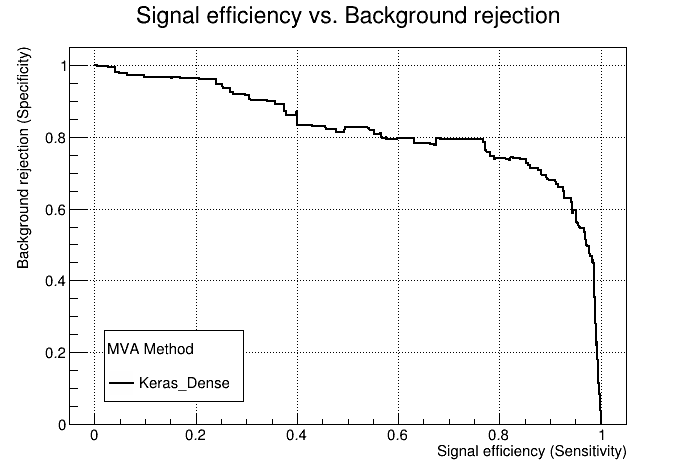

In [11]:
c1 = factory.GetROCCurve(loader)
c1.Draw()

## DNN Complete Function

In [3]:
def get_params(file):
    params = []
    first = 1
    with open(file, 'r') as fp:
        line = fp.readline().rstrip()
        while line:
            if (file.split('.')[1] == 'csv' and first):
                first = 0
                line = fp.readline().rstrip()
                continue
            params.append(line)
            line = fp.readline().rstrip()       
    return params

In [4]:
def DNN(params, training, model_input, comp_params, model_name, config, comb):
    
    output_file = config+ "_" + comb + "_DNN_Classification.root"
    signal_file = config+"_s.root"
    backg_file = config+"_b.root"
    
    signal_input = ROOT.TFile(signal_file)
    signal_tree = signal_input.Nominal
    
    backg_input = ROOT.TFile(backg_file)
    backg_tree = backg_input.Nominal
    
    outputFile = ROOT.TFile.Open(output_file, "RECREATE")

    # Factory
    factory = ROOT.TMVA.Factory("TMVA_Higgs_Classification_"+config+"_"+comb, outputFile,
                          "!V:ROC:Silent:Color:!DrawProgressBar:AnalysisType=Classification" )

    loader = ROOT.TMVA.DataLoader("dataset")

    ### global event weights per tree (see below for setting event-wise weights)
    #signalWeight     = 1.0
    #backgroundWeight = 1.0

    ### You can add an arbitrary number of signal or background trees
    loader.AddSignalTree    ( signal_tree )
    loader.AddBackgroundTree( backg_tree )
    loader.SetWeightExpression("EventWeight")
    
    not_cons = ['sample', 'EventWeight', 'EventNumber', 'm_region', 'm_FJNbtagJets', 'm_FJphi', 'm_FJeta', 'm_DTeta', 'm_DTphi']

    ## Define input variables 
    for branch in backg_tree.GetListOfBranches():
        if branch.GetName() in not_cons:
            continue
        loader.AddVariable(branch.GetName())
        
    mycuts = ROOT.TCut("")   ## for example: TCut mycuts = "abs(var1)<0.5 && abs(var2-0.5)<1";
    mycutb = ROOT.TCut("")   ## for example: TCut mycutb = "abs(var1)<0.5";


    loader.PrepareTrainingAndTestTree(mycuts, mycutb, training)
    
    # Model structure
    
    comp_params = comp_params.rstrip()
    comp_params = comp_params.split(',')
    loss = comp_params[0]
    
    comp_params.remove(loss)
    metrics = comp_params
    
    model = Sequential()
    model_input = model_input.rstrip()
    model_input = model_input.split(',')
    
    hidden_l = int(model_input[0])
    neurons = int(model_input[1])
    neurons_LF = int(model_input[2])
    k_init = model_input[3]
    activation_IL = model_input[4]
    activation_HL = model_input[5]
    activation_FL = model_input[6]
    
    print(type(neurons))
    
    model.add(Dense(neurons, kernel_initializer=k_init, activation=activation_IL, input_dim=10))
    for h in range(hidden_l):
        model.add(Dense(neurons, kernel_initializer=k_init, activation=activation_HL))
        
    model.add(Dense(neurons_LF, kernel_initializer=k_init, activation=activation_FL))
    
    # Set loss and optimizer
    model.compile(loss=loss, optimizer=Adam(), metrics=metrics)
    # Store model to file
    model.save(model_name)
    # Print summary of model
    model.summary()
    
    ## DNN method
    factory.BookMethod(loader,ROOT.TMVA.Types.kPyKeras, "Keras_Dense", params)
        
    factory.TrainAllMethods()
    
    factory.TestAllMethods()
    
    factory.EvaluateAllMethods()
    
    c1 = factory.GetROCCurve(loader)
    #c1.Draw()
    
    integ = factory.GetROCIntegral(loader, "Keras_Dense")
    
    print("ROC integral:", integ)
    
    outputFile.Close()
    signal_input.Close()
    backg_input.Close()
    
    return integ

## Parameters Combination

In [10]:
def write_combs_params(file_params, file_training, file_model, comp_params, model_name, arr_NumEpochs, arr_BatchSize, arr_nTrain_Signal, arr_nTrain_Background, arr_number_HL, arr_neurons, arr_neurons_LF, arr_k_init, arr_activation_IL, arr_activation_HL, arr_activation_FL, arr_loss, arr_metrics):
    comb_params = list(itertools.product(arr_NumEpochs, arr_BatchSize, arr_nTrain_Signal, arr_nTrain_Background, arr_number_HL, arr_neurons, arr_neurons_LF, arr_k_init, arr_activation_IL, arr_activation_HL, arr_activation_FL, arr_loss, arr_metrics))
    with open(file_params, 'w') as params, open(file_training, 'w') as training, open(file_model, 'w') as model, open(comp_params, 'w') as comp_p:
        model.write("number_HL,neurons,neurons_LF,k_init,activation_IL,activation_HL,activation_FL\n")
        for cp in comb_params:
            string1 = "H:!V:VarTransform=N_AllClasses:FilenameModel="+model_name+":NumEpochs="+str(cp[0])+":BatchSize="+str(cp[1])+":TriesEarlyStopping=10\n"
            params.write(string1)
            string2 = "nTrain_Signal="+str(cp[2])+"%:nTrain_Background="+str(cp[3])+"%:SplitMode=Random:NormMode=NumEvents:!V\n"
            training.write(string2)
            string3 = str(cp[4])+','+str(cp[5])+','+str(cp[6])+','+str(cp[7])+','+str(cp[8])+','+str(cp[9])+','+str(cp[10])+'\n'
            model.write(string3)
            string4 = str(cp[11])+','+str(cp[12])+'\n'
            comp_p.write(string4)

In [14]:
file_params="dnn_params2.txt"
file_training="dnn_training2.txt"
file_model="dnn_model2.csv"
file_comp_params='comp_params.txt'
model_name="model_dense.h5"
arr_NumEpochs=[100]
arr_BatchSize=[64]
arr_nTrain_Signal=[80]
arr_nTrain_Background=[80]
arr_number_HL=[3]
arr_neurons=[100]
arr_neurons_LF=[2]
arr_k_init=['he_uniform']
arr_activation_IL=['relu']
arr_activation_HL=['selu']
arr_activation_FL=['softmax']
arr_loss=['poisson']
arr_metrics=[f1]

In [15]:
write_combs_params(file_params, file_training, file_model, file_comp_params, model_name, arr_NumEpochs, arr_BatchSize, arr_nTrain_Signal, arr_nTrain_Background, arr_number_HL, arr_neurons, arr_neurons_LF, arr_k_init, arr_activation_IL, arr_activation_HL, arr_activation_FL, arr_loss, arr_metrics)

## Hyperparameter Optimization

In [5]:
def param_opt(config, params, training, model, comp_params, model_name):
    max_roc = 0
    best_params = ""
    best_train = ""
    best_model = ""
    print(config)
    print("===============")
    for i in range(len(params)):
        roc = DNN(params[i], training[i], model[i], comp_params[i], model_name, config)
        print("i:",i)
        print("ROC:", roc)
        if roc > max_roc:
            max_roc = roc
            best_params = params[i]
            best_train = training[i]
            best_model = model[i]
            best_comp = comp_params[i]
    best_model = best_model.split(',')
    best_model_str = "numero_HL="+str(best_model[0])+", neurons="+str(best_model[1])+", neurons_LF="+str(best_model[2])+", k_init="+str(best_model[3])+", activation_IL="+str(best_model[4])+", activation_HL="+str(best_model[5])+", activation_FL="+str(best_model[6])
    best_comp = best_comp.split(',')
    best_comp_str = "loss="+best_comp[0]+", metrics="+best_comp[1]
    print("best parameters:", best_params)
    print("best training:", best_train)
    print("best model:", best_model_str)
    print("best comps:", best_comp_str)
    print("ROC integral:", max_roc)
    return

In [12]:
params_path = "dnn_params2.txt"
params = get_params(params_path)
training_path = "dnn_training2.txt"
training = get_params(training_path)
configs = ["PreSel_0tag_Xtohh1000", "PreSel_1tag_Xtohh1000", "PreSel_2tag_Xtohh1000", 
           "QCDCR_0tag_Xtohh1000", "QCDCR_1tag_Xtohh1000", "QCDCR_2tag_Xtohh1000",
           "SR_0tag_Xtohh1000", "SR_1tag_Xtohh1000", "SR_2tag_Xtohh1000",
           "PreSel_0tag_Xtohh2000", "PreSel_1tag_Xtohh2000", "PreSel_2tag_Xtohh2000",
           "QCDCR_0tag_Xtohh2000", "QCDCR_1tag_Xtohh2000", "QCDCR_2tag_Xtohh2000",
           "SR_0tag_Xtohh2000", "SR_1tag_Xtohh2000", "SR_2tag_Xtohh2000"]
s_end = "_s.root"
b_end = "_b.root"
comp_params_path = "comp_params.txt"
comp_params = get_params(comp_params_path)
model_input_path = "dnn_model2.csv"
model_input = get_params(model_input_path)
model_name = "model_dense.h5"

In [14]:
#params_ = "H:!V:VarTransform=N_AllClasses:FilenameModel=model_dense.h5:NumEpochs=300:BatchSize=64:TriesEarlyStopping=10"
#model_input_ = "3,20,2,he_uniform,relu,selu,softmax"
#comp_params_ = "binary_crossentropy,binary_accuracy"
#training_ = "nTrain_Signal=80%:nTrain_Background=70%:SplitMode=Random:NormMode=NumEvents:!V"
#model_name_ = "model_dense.h5"
#comb = "COMB5"
#DNN(params_, training_, model_input_, comp_params_, model_name_, configs[17], comb)

In [13]:
#param_opt(configs[17], params, training, model_input, comp_params, model_name)

# Prediction

In [5]:
# Add weights
def v_out(tree, not_cons, variables, reader):
    
    h = ROOT.TH1D("","",60,-1,1)
    
    nevt = tree.GetEntries()

    vout = np.arange(nevt, dtype='float').reshape(1, nevt)

    for ievt, entry in enumerate(tree):
        i = 0    
        for branch in tree.GetListOfBranches():
            name = branch.GetName()
            if name in not_cons:
                continue
            variables[i][0] = getattr(entry,name)
            i += 1

        vout[0,ievt] = reader.EvaluateMVA(methodName)
        h.Fill(vout[0,ievt])
    
    return h, vout, variables

In [6]:
def gen_report_pred(background, signal, data, sep):
    background = list(background[0])
    signal = list(signal[0])
    data = list(data[0])
    bakg_t = [0]*len(background)
    signal_t = [1]*len(signal)
    y_predicted = background + signal
    y_test = bakg_t + signal_t
    for i in range(len(y_predicted)):
        if (y_predicted[i] < sep):
            y_predicted[i] = 0
        else:
            y_predicted[i] = 1
    for j in range(len(data)):
        if (data[j] < sep):
            data[j] = 0
        else:
            data[j] = 1
    print(classification_report(y_test, y_predicted, target_names=["background", "signal"]))
    print("Accuracy total:", accuracy_score(y_test, y_predicted))
    #print("Confusion matrix:", confusion_matrix(y_test, data))
    return data

In [7]:
def predict(config, type_signal, methodName, sep, comb):
    reader = TMVA.Reader( "!Color:!Silent" )
    
    dataPath = config + "_" + type_signal + "_d.root"
    bkgPath = config + "_" + type_signal + "_b.root"
    sigPath = config + "_" + type_signal + "_s.root"
    
    print(dataPath)
    
    dataFile = ROOT.TFile(dataPath)
    bkgFile = ROOT.TFile(bkgPath)
    sigFile = ROOT.TFile(sigPath)

    dataTree = dataFile.Nominal
    bkgTree = bkgFile.Nominal
    sigTree = sigFile.Nominal
    
    # Add Variables: We add variables to the reader exactly in the same way we did for the **DataLoader** during the training
    # We need to specify the address of the variable in order to pass it to TMVA when we iterate on the TTree
    variables = []
    i = 0
    
    not_cons = ['sample', 'EventWeight', 'EventNumber', 'm_region', 'm_FJNbtagJets', 'm_FJphi', 'm_FJeta', 'm_DTeta', 'm_DTphi']
    
    for branch in dataTree.GetListOfBranches():
        if branch.GetName() in not_cons:
            continue
        aux = array('f',[0])
        variables.append(aux)
        reader.AddVariable(branch.GetName(),variables[i])
        i = i+1
    
    # Setup Classifiers: We set up the classifiers by reading the input weights from the appropriate files
    # The file is stored for example as *dataset/weights/TMVAClassification_BDT.weights.xml
    weightfile = "dataset/weights/TMVA_Higgs_Classification_"+ config + "_" + type_signal + "_" + comb + "_" + methodName + ".weights.xml" #_" + config + "_" + type_signal + "_" + comb + "_" + methodName + "
    name = ROOT.TString(methodName)
    reader.BookMVA( name, weightfile )
    
    # We iterate on the input event in the given TTree. We provide as input first the background tree 
    # We return the output results for the various methods in big numpy array [ number of methods x 
    # number of events]
    # We also fill an histogram for each method.
    # Note that is important to fill the arrays with the tree entries in order to pass the values to 
    # the TMVA::Reader
    variables2 = variables
    
    hd, d_vout, variables = v_out(dataTree, not_cons, variables, reader)
    hs, s_vout, variables = v_out(sigTree, not_cons, variables, reader)
    hb, b_vout, variables = v_out(bkgTree, not_cons, variables, reader)
    
    print("Signal size:", len(s_vout[0]))
    print("Background size:", len(b_vout[0]))
    
    # Classification report
    prediction = gen_report_pred(b_vout, s_vout, d_vout, sep)
    
    print("Prediction size:", len(prediction))
    
    # Histogram
    c1 = ROOT.TCanvas("c1", "c1")
    c1.cd()
    hb.Draw()
    hs.SetLineColor(ROOT.kRed)
    hd.SetFillColor(ROOT.kGreen)
    hb.SetFillColor(ROOT.kBlue)
    hb.Draw()
    hs.Draw('Same')
    hd.Draw('Same')
    hb.SetTitle("background")
    hs.SetTitle("signal")
    hd.SetTitle("data")
    c1.BuildLegend()
        
    img_file = config + "_" + type_signal + "_" + comb + "_" + methodName + "_hist.png"
    c1.SaveAs(img_file)
    
    dataFile.Close()
    sigFile.Close()
    bkgFile.Close()
    
    display(Image(filename=img_file)) 
    
    return prediction

In [8]:
import struct

def predict_test(config, type_signal, methodName, sep, comb):
    
    reader = TMVA.Reader( "!Color:!Silent" )
    data_input = config + "_" + type_signal + "_" + comb + "_DNN_Classification.root"
    data = ROOT.TFile(data_input)
    testTree = data.Get("dataset/TestTree")
    
    array_ = tree2array(testTree)
    className = pd.DataFrame(array_)
    className = className['className']
    true = []
    
    for el in className:
        if el == b'Background':
            true.append(0)
        else:
            true.append(1)
    
    variables = []
    i = 0
    
    not_cons = ['classID', 'className', 'weight', 'Keras_Dense']
    
    for branch in testTree.GetListOfBranches():
        if branch.GetName() in not_cons:
            continue
        aux = array('f',[0])
        variables.append(aux)
        reader.AddVariable(branch.GetName(),variables[i])
        i = i+1
    
    weightfile = "dataset/weights/TMVA_Higgs_Classification_"+ config + "_" + type_signal + "_" + comb + "_" + methodName + ".weights.xml" #_" + config + "_" + type_signal + "_" + comb + "_" + methodName + "
    name = ROOT.TString(methodName)
    reader.BookMVA( name, weightfile )
    
    ht, t_vout, variables = v_out(testTree, not_cons, variables, reader)
    
    pred = []
    for el in t_vout[0]:
        if el <= sep:
            pred.append(0)
        else:
            pred.append(1)
    
    print("Test set size:", len(t_vout[0]))

    print(classification_report(true, pred))
    print("Accuracy:", accuracy_score(true, pred))
    matrix = confusion_matrix(true, pred)
    print("Confusion matrix:")
    print(matrix[0])
    print(matrix[1]) 
    

In [17]:
config = "SR_2tag"
type_signal = "Xtohh2000"
methodName = "Keras_Dense"
sep = 0.5
comb = "COMB2"
asd = predict_test(config, type_signal, methodName, sep, comb)

Test set size: 11728
             precision    recall  f1-score   support

          0       0.01      0.38      0.03       359
          1       0.86      0.12      0.22     11369

avg / total       0.84      0.13      0.21     11728

Accuracy: 0.13071282401091405
Confusion matrix:
[135 224]
[9971 1398]
                         : Booking "Keras_Dense" of type "PyKeras" from dataset/weights/TMVA_Higgs_Classification_SR_2tag_Xtohh2000_COMB2_Keras_Dense.weights.xml.
                         : Reading weight file: dataset/weights/TMVA_Higgs_Classification_SR_2tag_Xtohh2000_COMB2_Keras_Dense.weights.xml
<HEADER> DataSetInfo              : [Default] : Added class "Signal"
<HEADER> DataSetInfo              : [Default] : Added class "Background"
                         : Booked classifier "Keras_Dense" of type: "PyKeras"
                         : Load model from file: dataset/weights/TrainedModel_Keras_Dense.h5
